### Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.generators import random_walks


/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# 1. Prepare Time Series Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 76)


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,851,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1553,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404,2016.0,Detroit,42.4190,-83.0393,35.0,35.0,35.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383,2016.0,Washington,38.9030,-76.9820,46.0,46.0,46.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,6369,2015.0,Pittsburgh,40.4621,-80.0308,65.0,65.0,65.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


## 1.1 Select cities

In [3]:
dataset['year'].value_counts()

year
2017.0    61389
2016.0    58724
2015.0    53335
2014.0    51684
2018.0    13801
2013.0      448
Name: count, dtype: int64

Keep only incidents regarding [2014, 2015, 2016, 2017], as by project assignment instructions.

In [4]:
dataset = dataset[(dataset['year'] > 2013) & (dataset['year'] < 2018)]

Analysis of cities reveals that many cities are present with different names, resulting in incorrect city value counts.

In [5]:
with open('debugging/cities.txt', 'w') as f:
    for item in dataset['city_or_county'].unique():
        f.write("%s\n" % item)
        
# Write city and value counts of each city to a file
with open('debugging/city_counts.txt', 'w') as f:
    f.write(dataset['city_or_county'].value_counts().to_string())

print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))
        

There are 12596 unique cities in the dataset


Eliminate parenthesis with county or extra information.

In [6]:
# Eliminate all data between parenthesis in the city column using re module
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: re.sub(r"\(.*\)", "", x))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 11762 unique cities in the dataset


Sort cities alphabetically to see if there are still duplicates and how relevant they are.

In [7]:
# Get all cities and sort them alphabetically and write them in a file
cities = dataset['city_or_county'].unique()
cities.sort()
with open('debugging/cities2.txt', 'w') as f:
    for item in cities:
        f.write("%s\n" % item)

We can see that there are many cities which differ in having a space in the end, let's remove all spaces to avoid problems.

In [8]:
# Remove all spaces from city names
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: x.replace(" ", ""))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10416 unique cities in the dataset


In [9]:
dataset['city_or_county'] = dataset['city_or_county'].str.upper()
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10331 unique cities in the dataset


Introducing a week parameter and filtering only cities with a number of weeks with incidents greater than 15% of the total number of the weeks of the 4 years.

In [10]:
dataset['week'] = " "

# Date attribute is a progressive integer number, starting from 0
# Assign a week number to each date
dataset['date'] = dataset['date'] - dataset['date'].min()
dataset['week'] = dataset['date'].apply(lambda x: int(x / 7))

n_weeks = dataset['week'].max()
n_weeks

881

In [11]:
cities = dataset['city_or_county'].unique()
dropping_threshold = 0.01

for city in cities:
    city_data = dataset[dataset['city_or_county'] == city]
    city_weeks_with_incidents = city_data['week'].nunique()

    # Drop the city if it has less than 15% of the weeks with incidents
    if city_weeks_with_incidents < n_weeks * dropping_threshold:
        dataset = dataset[dataset['city_or_county'] != city]

print('Number of cities for which time series will be generated:', dataset['city_or_county'].nunique())
dataset.head()

Number of cities for which time series will be generated: 2139


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y,week
0,486,2015.0,INDIANAPOLIS,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,5.000000e-01,-0.866025,69
2,1039,2016.0,DETROIT,42.4190,-83.0393,35.0,35.0,35.0,0.0,1.0,...,False,False,False,False,False,False,False,-5.000000e-01,0.866025,148
3,1018,2016.0,WASHINGTON,38.9030,-76.9820,46.0,46.0,46.0,0.0,1.0,...,False,False,False,False,False,False,False,-8.660254e-01,0.500000,145
4,6004,2015.0,PITTSBURGH,40.4621,-80.0308,65.0,65.0,65.0,0.0,1.0,...,False,False,False,False,False,False,False,1.224647e-16,-1.000000,857
5,17,2014.0,WAYNECOUNTY,35.1847,-77.9527,65.0,65.0,65.0,0.0,1.0,...,False,False,False,False,False,False,False,5.000000e-01,0.866025,2


## 1.2 Score functions for subtasks

Define the functions to compute the score for each of the two subtasks

In [21]:
def compute_week_score(week_data, task):
    # Compute the score for a given week, to be used in the time series
    match task:
        case 'task1':
            score = (week_data['killed_ratio'] * week_data['n_participants']).sum()
        case _:
            raise ValueError('Task not recognized')
    return score

def generate_time_series(city_data, n_weeks, task):
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, task)
    return time_series

def generate_time_series_dataset(dataset, task):
    # Generate the time series for all cities
    n_weeks = dataset['week'].max()
    cities = dataset['city'].unique()
    time_series = []
    for city in cities:
        city_data = dataset[dataset['city'] == city]
        time_series.append(generate_time_series(city_data, n_weeks, task))
    return np.array(time_series)

# 2. Clustering and Motif/Anomalies Extraction 

## 2.1 Generate time series

In [22]:
ts_dataset = generate_time_series_dataset(dataset, 'task1')
ts_dataset.shape

(2139, 881)

In [24]:
X = ts_dataset

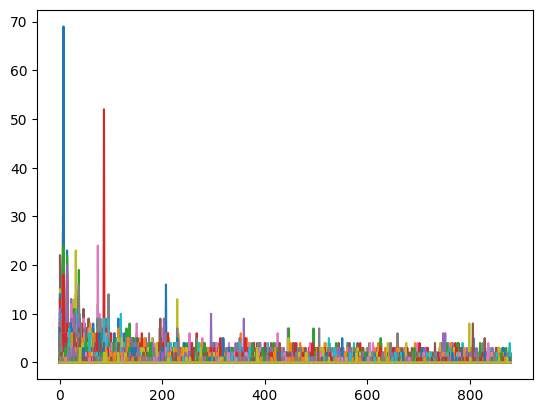

In [25]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

## 2.2 Clustering 

In [28]:
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=10, n_clusters=5, random_state=0)

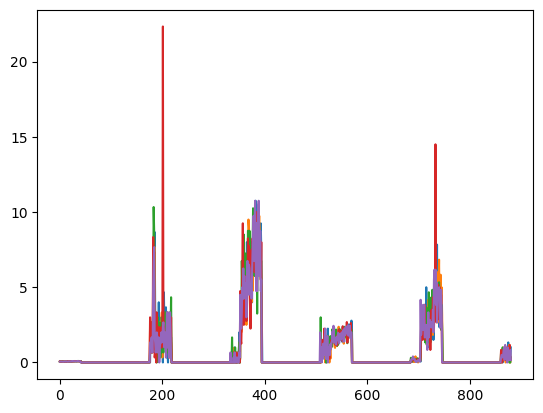

In [29]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

In [30]:
km_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

In [ ]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

In [ ]:
ks = KShape(n_clusters=3, n_init=1, random_state=0).fit(X)
ks.cluster_centers_.shape

In [ ]:
plt.plot(ks.cluster_centers_.reshape(X.shape[1], 5))
plt.show()